# Aidge demonstration

Aidge is a collaborative **open source deep learning library** optimized for exporting and processing deep learning algorithms on **embedded devices**. With Aidge, one you can create or import a _computational graph_ from popular frameworks, apply modification to its structure, train it and export its architecture to various embedded devices. Aidge provides optimized functions for both inference and training, as well as many custom functionalities for the target device.

This notebook put in perspective the tool chain to import a Deep Neural Network from ONNX model and support its Inference in Aidge. The tool chain demonstrated is: 

![pipeline(0)](./static/pipeline0.png)
 
In order to demonstrate this toolchain, the MNIST digit recognition task is used.

![MNIST](./static/MnistExamples.png)

## Setting up the notebook

In [1]:
# First import some utility methods used in the tutorial:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
import tuto_utils

### (if needed) Download the model
If you don't have git-lfs, you can download the model and data using this piece of code

In [2]:
# Download onnx model file
tuto_utils.download_material("101_first_step", "MLP_MNIST.onnx")
# Download input data
tuto_utils.download_material("101_first_step", "input_digit.npy")
# Download output data for later comparison
tuto_utils.download_material("101_first_step", "output_digit.npy")

## Import Aidge

In order to provide a colaborative environnement in the platform, the structure of Aidge is built on a core library that interfaces with multiple modules binded to python libraries. 

- aidge_core is the core library which offers all the basic functionnalities to create and manipulate the internal computational graph representation;
- aidge_backend_cpu is a C++ module providing a generic C++ implementations for each component of the computational graph;
- aidge_onnx is a module allowing to import ONNX to the Aidge framework;
- aidge_export_cpp is a module dedicated to the generation of optimized C++ code.


This way, aidge_core is free of any dependencies and the user can install whatever they want depending on their use case.

![modular](./static/modular.png)

In [3]:
import aidge_core

# Conv2D Operator is available but only the "export_serialize" is available.
# This backend allow to generate C++ code but not to run inference.
# For this we would need "cpu" backend.
print(f"Available backends:\n{aidge_core.get_keys_Conv2DOp()}")

# note: Tensor is a special case as 'cpu' backend is provided in the core
# module to guarantee basic functionalities such as data accesss
print(f"Available backends for Tensor:\n{aidge_core.Tensor.get_available_backends()}")

Available backends:
{'export_serialize'}
Available backends for Tensor:
{'cpu'}


 As one can see, only an export backend is available for the class Conv2D, which is ``export_serialize``. One needs to import the ``aidge_backend_cpu`` module which automatically registers itself to ``aidge_core``, giving access to a backend that is able to run an inference.

In [4]:
import aidge_backend_cpu

print(f"Available backends:\n{aidge_core.get_keys_Conv2DOp()}")


Available backends:
{'cpu', 'export_serialize'}


For this tutorial, we will need to import ``aidge_onnx`` in order to load ONNX files, numpy in order to load data and matplotlib to display images.

In [5]:

import aidge_onnx
import numpy as np
import matplotlib.pyplot as plt


## ONNX Import

![pipeline(1)](./static/pipeline1.png)

In [6]:
model = aidge_onnx.load_onnx("MLP_MNIST.onnx")

Loading node using a generic operator.
Please report this issue at https://gitlab.eclipse.org/eclipse/aidge/aidge_onnx
by providing your ONNX model and the following error:
ONNX_NODE_CONVERTER_ returned: module 'aidge_core' has no attribute 'Flatten'
- Flatten (Flatten | GenericOperator)
	- axis : 1
- fc1_Gemm (Gemm)
- Relu (Relu)
- fc2_Gemm (Gemm)
- Relu_1 (Relu)
- fc3_Gemm (Gemm)


As you can see in the logs, aidge imported a Node as a ``GenericOperator``:

```
- /Flatten_output_0 (Flatten | GenericOperator)
```

This is a fallback mechanism which allows Aidge to load the entirety of an ONNX graph without failing, even when encountering a node that is not yet available in Aidge.

The ``GenericOperator`` acts as a stub retrieving the node's type and attributes from ONNX. This allows the user to provide these nodes an implementation in a user script or remove/replace them using Aidge's recipes, as detailed hereafter.
You can visualize the graph using the ``save`` method and the mermaid visualizer we have setup.


In [7]:
model.save("myModel")
tuto_utils.visualize_mmd("myModel.mmd")

## Graph transformation 

![pipeline(2)](static/pipeline2.png)

In order to support the graph for inference we need to support all operators.
The imported model contains ```Flatten``` before the ```Gemm```  operator. The ```aidge.FC``` operator already supports the flatten operation. 
Graph transformation is required to support the graph for inference, i.e. remove the ```Flatten``` operator. 

Aidge's graph transformation toolchain is embedded inside ``recipes`` functions. These recipes are available in ``aidge_core``.

Examples include:
- **fuse_batchnorm**: Fuse BatchNorm inside Conv or FC operator;
- **matmul_to_fc**: Fuse MatMul and Add operator into a FC operator;
- **conv_horizontal_tiling**: replace a conv by an horizontal tilled version;
- **remove_flatten**: Remove Flatten if it is before an FC operator;
- **adapt_to_backend**: Adapt graph to the current backend by adding Transpose layer to match expected input/output data format;
- **constant_folding**: Compute constant part of the graph and replace them by pre-computed values.

Let's apply the **remove_flatten** recipe:

In [8]:
# Use the remove_flatten recipe
aidge_core.remove_flatten(model)

The ``flatten`` node is removed with the recipie. Let's visualize the model:

In [9]:
model.save("mySupportedModel")
tuto_utils.visualize_mmd("mySupportedModel.mmd")

## Static analysis

![pipeline(3)](static/pipeline3.png)

Static analysis can be applied anytime on a graph in order to measure its complexity in terms of memory and operations.

In [10]:
import aidge_core.static_analysis

# Dims must be forwarded for static analysis!
model.forward_dims(dims=[[1, 1, 28, 28]], allow_data_dependency=True)

model_stats = aidge_core.static_analysis.StaticAnalysisExt(model)
model_stats.summary()

--------------------------------------------------------------------------------
                        Layer (type)               Output Shape         Param #
                     fc1_Gemm (FC#0)                    [1, 50]           39250
                       Relu (ReLU#0)                    [1, 50]               0
                     fc2_Gemm (FC#1)                    [1, 50]            2550
                     Relu_1 (ReLU#1)                    [1, 50]               0
                     fc3_Gemm (FC#2)                    [1, 10]             510
Total params: 42310
--------------------------------------------------------------------------------
Input size (MB): 0.00299072265625
Forward/backward pass size (MB): 0.00080108642578125
Params size (MB): 0.16139984130859375
Estimated Total Size (MB): 0.165191650390625
--------------------------------------------------------------------------------


[['fc1_Gemm (FC#0)', [0, 78400, 0, 0, 0]],
 ['Relu (ReLU#0)', [0, 0, 0, 50, 0]],
 ['fc2_Gemm (FC#1)', [0, 5000, 0, 0, 0]],
 ['Relu_1 (ReLU#1)', [0, 0, 0, 50, 0]],
 ['fc3_Gemm (FC#2)', [0, 1000, 0, 0, 0]]]

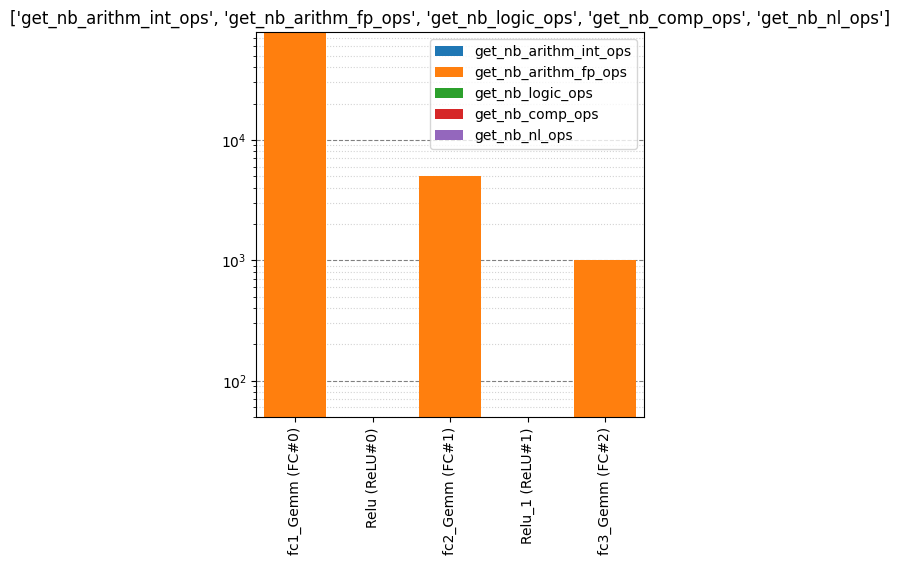

In [11]:
model_stats.log_nb_ops_by_type("stats_ops.png", log_scale=True)


## Inference

![pipeline(4)](./static/pipeline4.png)

### Create an input tensor

In order to perform an inference pass, we will load an image from the MNIST dataset using Numpy.

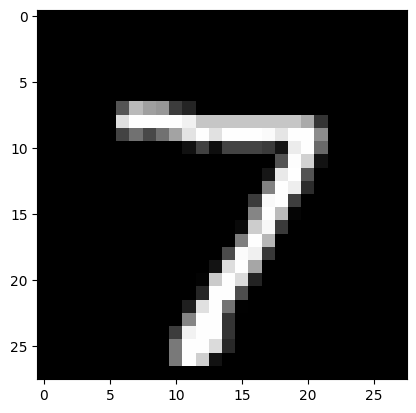

In [12]:
## Load input data & its output from the MNIST_model
digit = np.load("input_digit.npy")
plt.imshow(digit[0][0], cmap='gray')


And in order to validate the result our model will provide, we will also load the output the PyTorch model povided for this image

In [13]:
output_model = np.load("output_digit.npy")
print(output_model)


[[[ -1.3114135  -1.3960878   5.118178    5.338807   -8.182431
    -0.612254  -11.45598    13.0557165  -3.0393667   2.6212344]]]


Thanks to the Numpy interoperability we can create an Aidge ``Tensor`` using directly the numpy array storing the image.

In [14]:
input_tensor = aidge_core.Tensor(digit)
print(f"Aidge Input Tensor dimensions: \n{input_tensor.dims()}")


Aidge Input Tensor dimensions: 
[1, 1, 28, 28]


### Configure the model for inference

At the moment the model has no implementation, it is only a datastructure. To set an implementation we will set a dataype and a backend.

In [15]:
# Configure the model
model.compile("cpu", aidge_core.dtype.float32, dims=[[1,1,28,28]])
# equivalent to set_datatype(), set_backend() and forward_dims()

### Create a scheduler and run inference

The graph is ready to run ! We just need to schedule the execution, to do this we will create a ``Scheduler`` object, which will take the graph and generate an optimized scheduling using a consummer producer heuristic.


In [16]:
# Create SCHEDULER
scheduler = aidge_core.SequentialScheduler(model)

# Run inference !
scheduler.forward(data=[input_tensor])


Context: Consumer node fc1_Gemm (FC#0) input #0
No producer node attached to input#0 for node fc1_Gemm (FC)

Context: Consumer node fc1_Gemm (FC#0) input #0
No producer node attached to input#0 for node fc1_Gemm (FC)



In [17]:
# Assert results
for outNode in model.get_output_nodes():
    output_aidge = np.array(outNode.get_operator().get_output(0))
    print(output_aidge)
    print('Aidge prediction = ', np.argmax(output_aidge[0]))
    assert(np.allclose(output_aidge, output_model,rtol=1e-04))


[[ -1.3114134  -1.3960874   5.1181774   5.3388066  -8.182431   -0.6122534
  -11.455979   13.055716   -3.0393662   2.6212344]]
Aidge prediction =  7


It is possible to save the scheduling in a mermaid format using:

In [18]:
scheduler.save_scheduling_diagram("schedulingSequential")
tuto_utils.visualize_mmd("schedulingSequential.mmd")


## Optimize network

![pipeline(5)](static/pipeline5.png)


In [19]:
quantized_model = model.clone()

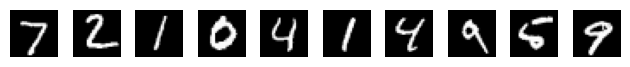

In [20]:
import gzip

NB_SAMPLES = 100 # Number of samples to use for PTQ

# Use data stored in PTQ tutorial, make sure to download them using git lfs
samples = np.load(gzip.GzipFile('../PTQ_tutorial/mnist_samples.npy.gz', "r"))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(samples[i], cmap='gray')

tensors = []
for sample in samples[0:NB_SAMPLES]:
    sample = np.reshape(sample, (1, 1, 28, 28)).astype(np.float32)
    tensor = aidge_core.Tensor(sample)
    tensors.append(tensor)

In [21]:
import aidge_quantization
aidge_quantization.quantize_network(
    quantized_model,
    8,
    tensors,
    clipping_mode   = aidge_quantization.Clipping.MSE,
    no_quantization  = False,
    optimize_signs  = True,
    single_shift    = False,
    use_cuda        = False)


 === QUANT PTQ 0.2.21 === 
 Preparing the network for the PTQ ... 
 Inserting the scaling nodes ...
Notice: the 0-th Parent of the child node Relu (of type ReLU) already existed
Filling a Tensor already attributed.
You are replacing an existing parent for node Relu (of type ReLU).
Notice: the 0-th Parent of the child node Relu_1 (of type ReLU) already existed
Filling a Tensor already attributed.
You are replacing an existing parent for node Relu_1 (of type ReLU).
 Applying the Cross-Layer Equalization ... 
 Normalizing the parameters ...
 Computing the value ranges ...
Context: Consumer node fc1_Gemm (FC#0) input #0
No producer node attached to input#0 for node fc1_Gemm (FC)

Context: Consumer node fc1_Gemm (FC#0) input #0
No producer node attached to input#0 for node fc1_Gemm (FC)

 Optimizing the clipping values ...
Context: Consumer node fc1_Gemm (FC#0) input #0
No producer node attached to input#0 for node fc1_Gemm (FC)

Context: Consumer node fc1_Gemm (FC#0) input #0
No producer n

In [22]:
quantized_model.save("quantizedModel")
tuto_utils.visualize_mmd("quantizedModel.mmd")

## Export

Now that we have tested the imported graph we can look at one of the main feature of Aidge, the export of computationnal graph to an hardware target using code generation.

![pipeline(6)](./static/pipeline6.png)

### Generate an export in C++
In this example we will generate a generic C++ export.
This export is not based on the `cpu` backend we have set before.

In this example we will create a standalone export which is abstracted from the Aidge platform.


In [23]:
! rm -r myexport


In [24]:
!ls myexport


ls: cannot access 'myexport': No such file or directory


Generating a ``cpu`` export recquires the ``aidge_export_cpp`` module.

Once the module is imported you just need one line to generate an export of the graph.

In [29]:
import aidge_export_cpp

# Configuration for the model + forward dimensions
model.compile("cpu", aidge_core.dtype.float32, dims=[[1, 1, 28, 28]])
# Export the model in C++ standalone
aidge_core.export_utils.scheduler_export(
        scheduler,
        "myexport",
        aidge_export_cpp.ExportLibCpp,
        memory_manager=aidge_core.mem_info.generate_optimized_memory_info,
        memory_manager_args={"stats_folder": "myexport/stats", "wrapping": False }
)

Generated memory management info at: myexport/stats/memory_info.png


The ``export_scheduler`` function will generate:

- **dnn/include/forward.hpp** define API function to use the export;
- **dnn/include/kernels** folders for kernels;
- **dnn/include/layers** layers configuration;
- **dnn/include/parameters** folder with parameters;
- **dnn/src/forward.cpp** source code of forward function which call kernels;
- **Makefile** To compile the main.cpp

In [30]:
!tree myexport


/bin/bash: line 1: tree: command not found


### Generate main file

Export scheduler only generates the export of the kernels and a forward function which calls the kernels in the order described by the scheduler.

From this point we can start building an application. In order to do so, Aidge proposes a utils function named ``generate_main_cpp``, which generates a simple main.cpp, able to perform an inference pass based on an input tensor provided by the user.

In [31]:
aidge_core.export_utils.generate_main_cpp("myexport", model)

gen : myexport/fc1_Gemm_input_0.h


In [32]:
!cat myexport/main.cpp


#include <iostream>
#include "forward.hpp"

#include "fc1_Gemm_input_0.h"




int main()
{
    // Initialize the output arrays
    float* fc3_Gemm_output_0 = nullptr;
    

    // Call the forward function
    model_forward(fc1_Gemm_input_0, &fc3_Gemm_output_0);

    // Print the results of each output
    printf("fc3_Gemm_output_0:\n");
    for (int o = 0; o < 10; ++o) {
        printf("%f ", fc3_Gemm_output_0[o]);
    }
    printf("\n");
    
    return 0;
}


### (Optional) Generate an input file for tests

To test the export we need to provide input data. The ``generate_main_cpp`` function automatically generates an input file using tensor set as an input. 

This is the case here, has we set an input tensor when running the forward pass, so we don't need to execute the following cell.
However, if no input has been set you need to manually generate the input file, to do so we can export a Numpy array using:

```python
aidge_core.export_utils.generate_input_file(export_folder="myexport", array_name="fc1_Gemm_input_0", tensor=aidge_core.Tensor(digit.reshape(-1)))
```

### Compile the export

Once the generation has been done, we can compile the export with a simple make command:

In [33]:
!cd myexport && make


g++  -O2 -Wall -Wextra -MMD -fopenmp -I. -I./dnn -I./dnn/include -I./dnn/layers -I./dnn/parameters -c main.cpp -o build/./main.o 
g++  -O2 -Wall -Wextra -MMD -fopenmp -I. -I./dnn -I./dnn/include -I./dnn/layers -I./dnn/parameters -c dnn/src/forward.cpp -o build/./dnn/src/forward.o 
g++  build/./main.o  build/./dnn/src/forward.o  -fopenmp -o bin/run_export


### Run the export

In [34]:
!./myexport/bin/run_export


fc3_Gemm_output_0:
-1.311413 -1.396087 5.118177 5.338807 -8.182431 -0.612253 -11.455979 13.055716 -3.039366 2.621234 
